In [203]:
import pandas as pd
import xgboost as xgb
import numpy as np
import shap
import os, fnmatch
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [226]:
# Get wd
os.getcwd()

# Start js
shap.initjs()

# Matplotlib in jupyter
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)

Populating the interactive namespace from numpy and matplotlib


/Users/fabianmueller/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Read data in and prepare for model

In [175]:
# Import data
df_train = pd.read_pickle('../data/prepared/train.pkl')

# Features
features = ['age',
            'breed1',
            'breed2',
            'gender',
            'color1',
            'color2',
            'color3',
            'maturitysize',
            'furlength',
            'vaccinated',
            'dewormed',
            'sterilized',
            'health',
            'quantity',
            'fee',
            'state',
            'videoamt',
            'photoamt',
            'description_length',
            'sentiment_magnitude',
            'sentiment_score']

# Target
target = 'adoptionspeed_bin'

# Make binary target
df_train.loc[:, target] = np.where(df_train.loc[:, 'adoptionspeed'] <= 2, 1, 0)

# Build feature matrix and labels
y = df_train.loc[:, target].ravel()
X = df_train.drop(target, axis=1)
X = X.loc[:, features]

# Split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Run XGBoost model

In [176]:
# Parameters
xgb_params = {'n_estimators': 100,
              'max_depth': 3,
              'reg_lambda': 0.01,
              'objective': 'binary:logistic'}

# Convert to xgb.DMatrix
xgb_train_df = xgb.DMatrix(X_train, label=y_train)
xgb_test_df = xgb.DMatrix(X_test, label=y_test)

# Train model
xgb_model = xgb.train(xgb_params, xgb_train_df)
fitted = xgb_model.predict(xgb_train_df)

# Eval model
p = xgb_model.predict(xgb_test_df)
score = roc_auc_score(y_true=y_test, y_score=p)
print("AUC score is {score}".format(score=score))

AUC score is 0.7062504732748456


### Get SHAP explainer ready

In [177]:
# Create data sample
background_samples = np.random.randint(low=0, high=X_train.shape[0], size=1000)

# Init SHAP explainer
xgb_explainer = shap.TreeExplainer(xgb_model, 
                                   data = X_train.sample(n=1000),
                                   feature_dependence="independent", 
                                   model_output='probability')

# Get SHAP values from explainer
xgb_shap_values = xgb_explainer.shap_values(X_train)

 98%|===================| 11034/11244 [00:13<00:00]        

### Search for example cases

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ec65dd8>]],
      dtype=object)

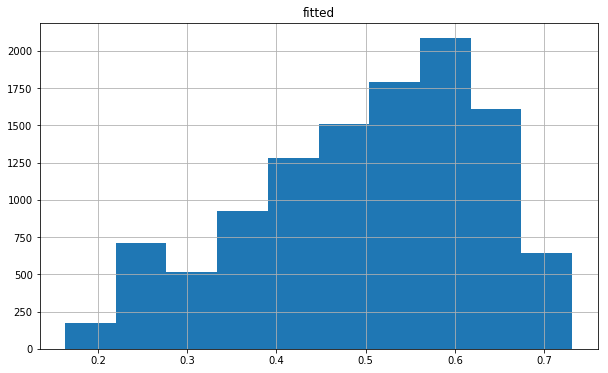

In [178]:
train_idx = X_train.index
pet_lookup = pd.DataFrame({'petid': df_train.petid.iloc[train_idx],
                          'fitted': fitted})
pet_lookup.hist(column='fitted')

In [296]:
# Get train images
train_images_path = '../data/raw/images/train_images'
train_images = fnmatch.filter(os.listdir(train_images_path), '*.jpg')

# Sample low/high end prob images
low_prob = pet_lookup.loc[pet_lookup.fitted < 0.2]
mid_prob = pet_lookup.loc[(pet_lookup.fitted > 0.565) & (pet_lookup.fitted < 0.568)]
high_prob = pet_lookup.loc[pet_lookup.fitted > 0.725]

# New paths
high_prob_path = '../data/prepared/images/train_images_high_prob'
low_prob_path = '../data/prepared/images/train_images_low_prob'
mid_prob_path = '../data/prepared/images/train_images_mid_prob'

# Copy samples
print("Copying low prob images")
for index, row in tqdm_notebook(low_prob.iterrows(), total=low_prob.shape[0]):
    files = [f for f in train_images if re.match('^' + row.petid, f)]
    
    for file in files:
        copyfile(train_images_path + '/' + file, 
                 low_prob_path + '/' + file)
        
print("Copying high prob images")
for index, row in tqdm_notebook(high_prob.iterrows(), total=high_prob.shape[0]):
    files = [f for f in train_images if re.match('^' + row.petid, f)]
    
    for file in files:
        copyfile(train_images_path + '/' + file, 
                 high_prob_path + '/' + file)
        
print("Copying mid prob images")
for index, row in tqdm_notebook(mid_prob.iterrows(), total=mid_prob.shape[0]):
    files = [f for f in train_images if re.match('^' + row.petid, f)]
    
    for file in files:
        copyfile(train_images_path + '/' + file, 
                 mid_prob_path + '/' + file)

Copying low prob images


Copying high prob images


Copying mid prob images


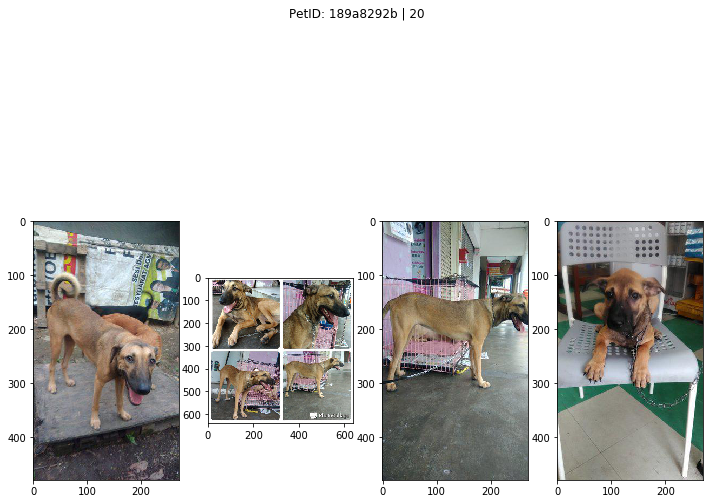

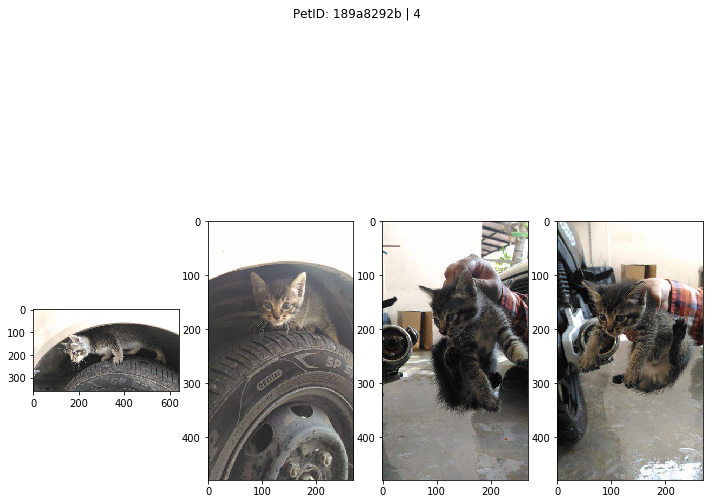

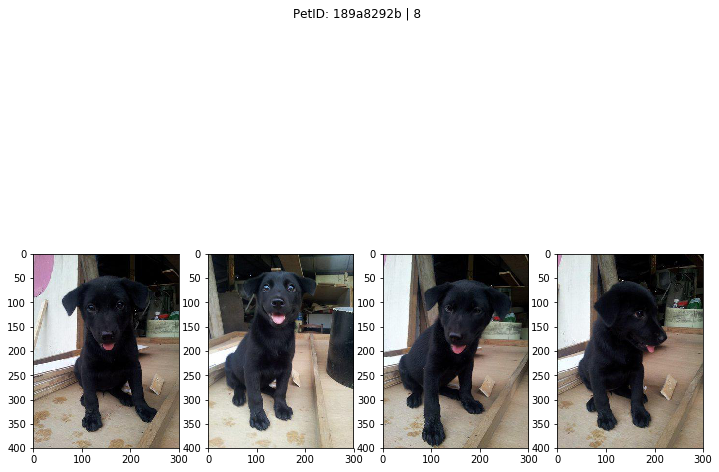

In [297]:
def get_and_show(petid, path, title=None):
    
    image_paths = fnmatch.filter(os.listdir(path), '*.jpg')
    files = [f for f in image_paths if re.match('^' + petid, f)]
    
    if len(files) == 1:
        img = mpimg.imread(path + "/" + files[0])
        imgplot = plt.imshow(img)
        plt.title('PetID: ' + str(row.petid) + ' | ' + str(len(files)))
        plt.show()
    
    if len(files) > 1:
        f, axarr = plt.subplots(1, len(files[:4]))
        f.suptitle('PetID: ' + str(row.petid) + ' | ' + str(len(files)))
        
        for i, file in enumerate(files[:4]):
            img = mpimg.imread(path + "/" + file)
            axarr[i].imshow(img)
            

# Example low prob
get_and_show('f394d4aad', low_prob_path) #b8bf2c090 bea72e6c5 f394d4aad

# Example high prob
get_and_show('d71310023', high_prob_path) # 1facdfb28 4c55ffdb7 05d3e4d55 25ffa1850 d71310023

# Example mid prob
get_and_show('1c92ce464', mid_prob_path) # 1c92ce464-4

In [ ]:
# Get train images
train_images_path = '../data/raw/images/train_images'
train_images = fnmatch.filter(os.listdir(train_images_path), '*.jpg')

# Sample low end prediction images
low_end = pet_lookup.loc[pet_lookup.fitted < 0.25].sample(n = 10)

# Show samples
for index, row in low_end.iterrows():
    files = [f for f in train_images if re.match('^' + row.petid, f)]
    
    if len(files) == 1:
        img = mpimg.imread(train_images_path + "/" + file)
        imgplot = plt.imshow(img)
        plt.title('PetID: ' + str(row.petid) + ' | ' + str(len(files)))
        plt.show()
    
    if len(files) > 1:
        f, axarr = plt.subplots(1, len(files))
        f.suptitle('PetID: ' + str(row.petid) + ' | ' + str(len(files)))
        
        for i, file in enumerate(files):
            img = mpimg.imread(train_images_path + "/" + file)
            axarr[i].imshow(img)


In [300]:
# High prob example in detail
high_prob_idx = df_train.loc[df_train.petid == 'd71310023', :].index.values
df_train.loc[df_train.petid == 'd71310023', features]

,age,breed1,breed2,gender,color1,color2,color3,maturitysize,furlength,vaccinated,...,sterilized,health,quantity,fee,state,videoamt,photoamt,description_length,sentiment_magnitude,sentiment_score
9783,1,265,0,1,1,6,0,2,2,2,...,2,1,1,0,41326,0,4.0,301.0,0.0,0.0


In [301]:
# Low prob example in detail
low_prob_idx = df_train.loc[df_train.petid == 'f394d4aad', :].index.values
df_train.loc[df_train.petid == 'f394d4aad', features]

,age,breed1,breed2,gender,color1,color2,color3,maturitysize,furlength,vaccinated,...,sterilized,health,quantity,fee,state,videoamt,photoamt,description_length,sentiment_magnitude,sentiment_score
9136,12,307,0,2,1,2,0,3,1,1,...,1,1,1,0,41326,0,20.0,248.0,2.2,0.3


In [302]:
# Mid prob example in detail
mid_prob_idx = df_train.loc[df_train.petid == '1c92ce464', :].index.values
df_train.loc[df_train.petid == '1c92ce464', features]

,age,breed1,breed2,gender,color1,color2,color3,maturitysize,furlength,vaccinated,...,sterilized,health,quantity,fee,state,videoamt,photoamt,description_length,sentiment_magnitude,sentiment_score
18,2,307,0,2,1,0,0,2,1,2,...,2,1,1,0,41401,0,8.0,680.0,1.8,0.1


### Explain single observations

#### High prob (Danny)

In [316]:
# Get row number in array
row_number = X_train.index.get_loc(high_prob_idx[0])

# Visualize high prob example
shap.force_plot(xgb_explainer.expected_value, 
                xgb_shap_values[row_number, :], 
                X_train.iloc[row_number, :])

In [317]:
high_prob_shap_values = pd.DataFrame({'feature': features,
                                      'shap_value': xgb_shap_values[row_number, :]})

high_prob_shap_values.sort_values('shap_value', ascending=False)

,feature,shap_value
0,age,0.109790
1,breed1,0.026575
3,gender,0.024857
11,sterilized,0.015548
17,photoamt,0.008316
13,quantity,0.008105
9,vaccinated,0.007783
2,breed2,0.004472
18,description_length,0.004467
10,dewormed,0.002637


#### Low prob (Big, Gentle Kat)

In [318]:
# Get row number in array
row_number = X_train.index.get_loc(low_prob_idx[0])

# Visualize high prob example
shap.force_plot(xgb_explainer.expected_value, 
                xgb_shap_values[row_number, :], 
                X_train.iloc[row_number, :])

In [319]:
low_prob_shap_values = pd.DataFrame({'feature': features,
                                      'shap_value': xgb_shap_values[row_number, :]})

low_prob_shap_values.sort_values('shap_value', ascending=False)

,feature,shap_value
15,state,0.005621
2,breed2,0.005070
13,quantity,0.003491
14,fee,0.001612
18,description_length,0.000323
12,health,0.000261
10,dewormed,0.000247
19,sentiment_magnitude,0.000000
6,color3,0.000000
7,maturitysize,0.000000


#### Mid prob (Beauty)

In [320]:
# Get row number in array
row_number = X_train.index.get_loc(mid_prob_idx[0])

# Visualize high prob example
shap.force_plot(xgb_explainer.expected_value, 
                xgb_shap_values[row_number, :], 
                X_train.iloc[row_number, :])

In [321]:
mid_prob_shap_values = pd.DataFrame({'feature': features,
                                      'shap_value': xgb_shap_values[row_number, :]})

mid_prob_shap_values.sort_values('shap_value', ascending=False)

,feature,shap_value
0,age,0.106117
9,vaccinated,0.015215
11,sterilized,0.012148
13,quantity,0.010527
2,breed2,0.004304
18,description_length,0.004267
20,sentiment_score,0.001804
17,photoamt,0.001100
14,fee,0.000646
5,color2,0.000432


### Other explainations

In [ ]:
xgb_shap_values = xgb_explainer.shap_values(X_train.iloc[0:1000, ])
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values, X_train.iloc[0:1000, ])

In [ ]:
shap.dependence_plot("age", xgb_shap_values, X_train)

In [ ]:
shap.summary_plot(xgb_shap_values, X_train)

In [ ]:
shap.summary_plot(xgb_shap_values, X_train, plot_type="bar")

In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb_model).shap_interaction_values(X_train)

shap.dependence_plot(("age", "quantity"),
                     shap_interaction_values, 
                     X_train,
                     display_features=X_train)